# PDF Reporting for Local Reports  
This notebook generates CDTA specific PDF reports.  
- Data from **Flood Net** from local 
- Data for **Flood Watch** from their "API"
- 311 data from Soda API  
- Tides data from NOAA or USGS
- Rainfall data

Generate visuals with given specs and place them in a folder with named saved to a variable to be placed in the report as image objects separatly.

## SETUP
- Import Libraries
- Adjust local folders
- Import and set font (make sure you have Source Sans installed)

Sensor Metadata is [here](https://docs.google.com/spreadsheets/d/1U2ngTsBOF1b9FOJ3H3hbW8tJ8OiVSceNoGyPg_4QpB8/edit?usp=sharing).  
CD's with sensors: Red Hook-Park Slope-Carroll Gardens, Howard Beach-Lindenwood, Port Richmond, Soundview, Williamsburg-Greenpoint, Grasmere-Arrochar-South Beach-Dongan Hills, Westerleigh-Castleton Corners, Bedford-Stuyvesant West, South Jamaica, Morningside Heights-Hamilton Heights, Morrisania-Crotona Park East, Arverne-Edgemere, New Springville-Willowbrook-Bulls Head-Travis, New Dorp Midland Beach, East Flatbush, Ocean Hill-Brownsville, Crown Heights South, Harlem, Queens Village-Bellerose-Rosedale, Greenwich Village-SoHo

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates as mdates
import geopandas as gpd
import contextily as ctx
import os
import requests
import colour

pd.set_option('display.max_columns', None)

blue = '#007acc'
light_blue = '#39A1FF'

report_folder = r'C:\Users\cansu\Dropbox\FloodNet_Report_Automation'
visual_folder = os.path.join(report_folder, "WEB_LAYOUT", "assets" , "IMG")
print(visual_folder)

# Create folder if not exist
if not os.path.exists(visual_folder): os.makedirs(visual_folder)

# PLT SET UP
# set font from local font file
from matplotlib import font_manager
font_dirs = [ r"C:\Users\cansu\AppData\Local\Microsoft\Windows\Fonts" ] # local fonts dir
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files: font_manager.fontManager.addfont(font_file)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.family'] = 'Source Sans 3'
mpl.rcParams['font.weight'] = 'regular'

# cd_name = 'Red Hook-Park Slope-Carroll Gardens'
cd_name = 'Howard Beach-Lindenwood'

C:\Users\cansu\Dropbox\FloodNet_Report_Automation\WEB_LAYOUT\assets\IMG


## Load and Prepare Data

### Sensor Data  
Simplify data to only used columns

In [83]:
def open_data(report_folder , data_name ):
    # Sensor Data is stored locally
    df = pd.read_parquet( os.path.join( report_folder, "Data", data_name ), engine='pyarrow' )

    df = df[[ 'time','deployment_id','depth_proc_mm','lat','lon','sensor_display_name','date_deployed' ]]
    df = df.dropna( subset=['depth_proc_mm'], axis=0 )
    df['time'] = pd.to_datetime( df['time'] )

    print( df.shape[0] , 'sensor readings' )
    return df

flood_data = open_data( report_folder , 'all_flood_data.parquet' )
flood_data.head(3)

13587472 sensor readings


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed
0,2023-05-01 00:00:01.363000+00:00,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022"
1,2023-05-01 00:00:01.913000+00:00,big_pink_elephant,124.0,40.655907,-73.828642,Q - 1st St/104th St,"March 17, 2023"
2,2023-05-01 00:00:07.955000+00:00,useless_crimson_rook,0.0,40.633346,-74.129583,SI - Jewett Ave/Castleton Ave,"July 22, 2022"


### Add CDTA information to Flood Data  
Data is not CDTA or NTA, something in between.

In [84]:
cdta = gpd.read_file( os.path.join( report_folder, 'Data', "report_boundaries_nta_cdta_11-2023.geojson" ) , crs=3857 )
cdta = cdta.to_crs( 4326 )

cdta = cdta[['CDTAName','labels','geometry']].rename(columns={'labels':'CDTALabel'})
cdta['CDTALabel'] = cdta['CDTALabel'].str.strip()
cdta.head(2)

,CDTAName,CDTALabel,geometry
0,SI01 North Shore (CD 1 Equivalent),St. George-New Brighton,"MULTIPOLYGON (((-74.08205 40.64831, -74.08187 ..."
1,SI01 North Shore (CD 1 Equivalent),Tompkinsville-Stapleton-Clifton-Fox Hills,"MULTIPOLYGON (((-74.07348 40.63779, -74.07346 ..."


In [85]:
def add_cdta_to_flood_data(df , cdta_boundaries ):

    if 'CDTAName' in df.columns: df = df.drop('CDTAName', axis=1)
    if 'CDTALabel' in df.columns: df = df.drop('CDTALabel', axis=1)

    # extract unique sensors so that we are not matching 1M records
    unique_Sensors = df.groupby('deployment_id').agg({
        'lat':'first',
        'lon':'first'
    })

    # Create a GeoDataFrame from the unique sensors and convert to NY State Plane
    geo_sensors = gpd.GeoDataFrame(unique_Sensors, geometry=gpd.points_from_xy(unique_Sensors.lon, unique_Sensors.lat), crs=4326 )

    # Spatial join the sensors to the CDTA polygons
    geo_sensors = geo_sensors.sjoin(cdta_boundaries[['CDTAName','CDTALabel','geometry']]).drop(['index_right','geometry','lat','lon'], axis=1)

    # Join to the flood data
    return  df.join(geo_sensors, on='deployment_id')

flood_data = add_cdta_to_flood_data( flood_data , cdta )
flood_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed,CDTAName,CDTALabel
0,2023-05-01 00:00:01.363000+00:00,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens
1,2023-05-01 00:00:01.913000+00:00,big_pink_elephant,124.0,40.655907,-73.828642,Q - 1st St/104th St,"March 17, 2023",QN10 South Ozone Park-Howard Beach (CD 10 Appr...,Howard Beach-Lindenwood
2,2023-05-01 00:00:07.955000+00:00,useless_crimson_rook,0.0,40.633346,-74.129583,SI - Jewett Ave/Castleton Ave,"July 22, 2022",SI01 North Shore (CD 1 Equivalent),Port Richmond


### Remove Non-Flood Events

In [86]:
events = pd.read_excel( os.path.join(report_folder, 'Data', 'flood_profiles_through_0523.xlsx'), sheet_name='flood_profiles')

def cleanup_events( df ):
    df = df[ df['Deployment_id'] != 'ugliest_cyan_elephant' ] # sensor on the water way 
    # df = df[ df['Class'] == 0 ].copy() # 0 is the code for floods

    df['Start_time'] = pd.to_datetime(df['Start_time'])
    df['End_time'] = pd.to_datetime(df['End_time'])

    df['Start_time'] = df['Start_time'].dt.tz_localize(None)
    df['End_time'] = df['End_time'].dt.tz_localize(None)

    # drop NaT values and create Intervals
    df = df.dropna(subset=['Start_time','End_time'])
    df['Interval'] =  df.apply( lambda x: pd.Interval(x['Start_time'],x['End_time'],closed='both'),axis=1) 

    # df = df.drop(['Borough','Type', 'Deployment_Date','Latitude','Longitude','Address'], axis=1)
    df = df.drop(['Drainage_time','Onset_rate','Drainage_rate','OnsetRate/DrainageRate','MaxDepth_OnsetRate','Time_avg_depth','Minutes','Onset_time'] , axis=1)
    df = df.dropna( axis=1, how='all' )
    df = df.drop( df.columns[df.columns.str.contains('Unnamed')] ,axis=1) 
    return df

events = cleanup_events(events)
events.head()

,Deployment_id,Address,Start_time,End_time,Max_depth_mm,Interval
0,asleep_apricot_bedbug,Staten Island - Willow Rd E/Nina Ave,2022-09-13 08:25:28,2022-09-13 08:46:44,46,"[2022-09-13 08:25:28, 2022-09-13 08:46:44]"
1,big_pink_elephant,Queens - 1st St/104th St,2023-03-31 09:49:44,2023-03-31 10:02:27,15,"[2023-03-31 09:49:44, 2023-03-31 10:02:27]"
2,big_pink_elephant,Queens - 1st St/104th St,2023-04-23 03:19:43,2023-04-23 03:46:06,21,"[2023-04-23 03:19:43, 2023-04-23 03:46:06]"
3,big_pink_elephant,Queens - 1st St/104th St,2023-04-30 21:24:03,2023-05-01 01:58:11,179,"[2023-04-30 21:24:03, 2023-05-01 01:58:11]"
4,blue_eyed_tiger,Brooklyn - Lee Ave/Middleton St,2023-04-30 21:22:03,2023-04-30 21:36:02,72,"[2023-04-30 21:22:03, 2023-04-30 21:36:02]"


In [87]:
def remove_non_flood_events(df_flood, df_events):
   """
   This function assigns 0 to depths that are not during a flood event.
   + converts the depth to inches
   time is in UTC for both dataframes
   Takes a while to run
   """
   
   df_flood['time'] = df_flood['time'].dt.tz_localize(None)
   df_flood['During Flood'] = False
   print( df_events.shape[0] , 'events will be tested' )

   count = 0
   matching_floods = pd.DataFrame()
   for sensor_id in df_flood['deployment_id'].unique():
      t_event = df_events[ (df_events['Deployment_id'] == sensor_id) ]
      t_flood = df_flood[ df_flood['deployment_id'] == sensor_id ].copy()

      for event_interval,sensor_id in zip(t_event['Interval'].values,t_event['Deployment_id'].values ):
         t_flood.loc[ 
            (t_flood['time'].between( event_interval.left, event_interval.right)) & 
            (t_flood['deployment_id'] == sensor_id) , 
            'During Flood'
            ] = True

      matching_floods = pd.concat([matching_floods, t_flood ])

   matching_floods['clean_depth'] = np.where( matching_floods['During Flood'] == True , matching_floods['depth_proc_mm'] , 0 )
   matching_floods['clean_depth_in'] = matching_floods['clean_depth'] / 25.4
   return matching_floods

flood_data = remove_non_flood_events(flood_data, events)
flood_data['time_NY'] = flood_data['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')

display(flood_data.head(3))

308 events will be tested


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
0,2023-05-01 00:00:01.363,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:00:01.363000-04:00
29,2023-05-01 00:01:04.640,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:01:04.640000-04:00
56,2023-05-01 00:02:07.403,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:02:07.403000-04:00


## PLOTS  
All plots will be generated here and will be saved in a PNG file in the `Charts` folder.

In [88]:
flood_data = flood_data[ flood_data['CDTALabel'].notnull() ]
local_data = flood_data[ flood_data['CDTALabel'] == cd_name ].copy()

### MAP 1: 
Main map on page 1:  
Flood sensor locations + frequency of days with floods

#### Query 311 Data


In [31]:

# polygon = local_cdta.dissolve().to_crs(4326)
# polygon1 = polygon.copy()
# polygon1.geometry = polygon1.geometry.simplify(0.001).buffer( 0.002 ).simplify(0.001)

C:\Users\cansu\AppData\Local\Temp\ipykernel_12764\4132011780.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon1.geometry = polygon1.geometry.simplify(0.001).buffer( 0.002 ).simplify(0.001)


In [89]:
def get_311_data( local_cdta ):
    data_311 = None
    data_query = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
    # Add more descriptors here
    descriptors = ['Street Flooding (SJ)','Catch Basin Clogged/Flooding (Use Comments) (SC)', 'Manhole Overflow (Use Comments) (SA1)' ]
    descriptors_filter = ' OR '.join([f"descriptor='{d}'" for d in descriptors])
    selectors = 'unique_key,created_date,agency,complaint_type,descriptor,status,latitude,longitude'

    start_date = ( pd.Timestamp.today() - pd.Timedelta(days=360*3))
    # start_date to the beginning of the year
    start_date = start_date.replace(month=1,day=1).date().strftime('%Y-%m-%d')

    polygon = local_cdta \
                    .dissolve() \
                    .to_crs(4326) \
                    .geometry.values[0]

    polygon = local_cdta \
                    .dissolve() \
                    .to_crs(4326) \

    polygon1 = polygon.copy()
    polygon1.geometry = polygon1.geometry.simplify(0.001).to_crs(2263).buffer( 1000 ).to_crs(4326).simplify(0.001)

    polygon_geom = polygon1.geometry.values[0]

    url = f"{data_query}?$where=within_polygon(location, '{polygon_geom}') AND created_date>'{start_date}' AND ({descriptors_filter})&$select={selectors}&$limit=5000"
    print( url )
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error {response.status_code}")
    else:
        data_311 = pd.DataFrame( response.json() )

    data_311 = gpd.GeoDataFrame(data_311.drop(['latitude','longitude'],axis=1), geometry=gpd.points_from_xy(data_311.longitude, data_311.latitude), crs=4326 )
    return data_311

local_cdta = cdta[cdta['CDTALabel'] == cd_name ].to_crs(3857)

data_311 = get_311_data( local_cdta )
data_311.head(3)

https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=within_polygon(location, 'POLYGON ((-73.86487370805943 40.65580519995338, -73.8665277032694 40.65927550507065, -73.86168328492866 40.66176309967003, -73.86186959717345 40.664272629020765, -73.85987868231675 40.66596335923268, -73.86051618182236 40.66851094443801, -73.86372868376415 40.670224694167025, -73.8648518379605 40.67556664614392, -73.86034780988592 40.67766399303158, -73.83065815608009 40.66859943742763, -73.82514082521298 40.65796792266617, -73.82280757511566 40.64804538720298, -73.82464381698074 40.645923796066896, -73.83234287109423 40.645215863063676, -73.83474764935372 40.6429045864424, -73.85042242362299 40.64147837694846, -73.85552192079781 40.645746133173574, -73.8555266148352 40.64857056335896, -73.85847218316941 40.64937117205719, -73.86487370805943 40.65580519995338))') AND created_date>'2021-01-01' AND (descriptor='Street Flooding (SJ)' OR descriptor='Catch Basin Clogged/Flooding (Use Comments) (SC)' OR de

,unique_key,created_date,agency,complaint_type,descriptor,status,geometry
0,59742627,2023-12-14T13:14:00.000,DEP,Sewer,Street Flooding (SJ),Closed,POINT (-73.84669 40.65161)
1,59743947,2023-12-14T10:05:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Open,POINT (-73.85397 40.66579)
2,59734827,2023-12-13T08:29:00.000,DEP,Sewer,Street Flooding (SJ),Closed,POINT (-73.85819 40.67013)


#### Plot Main map

C:\Users\cansu\AppData\Local\Temp\ipykernel_12764\2459887656.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  t2 = no_flooding.plot( ax=ax, markersize=50, fc='none', ec='black', lw=0.5 , zorder=10 )
c:\Users\cansu\.conda\envs\flood_report\Lib\site-packages\adjustText\__init__.py:567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  transform = texts[0].get_transform()
c:\Users\cansu\.conda\envs\flood_report\Lib\site-packages\adjustText\__init__.py:571: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  x[ix] = t_x
c:\Users\cansu\.conda\envs\flood_report\Lib\site-pac

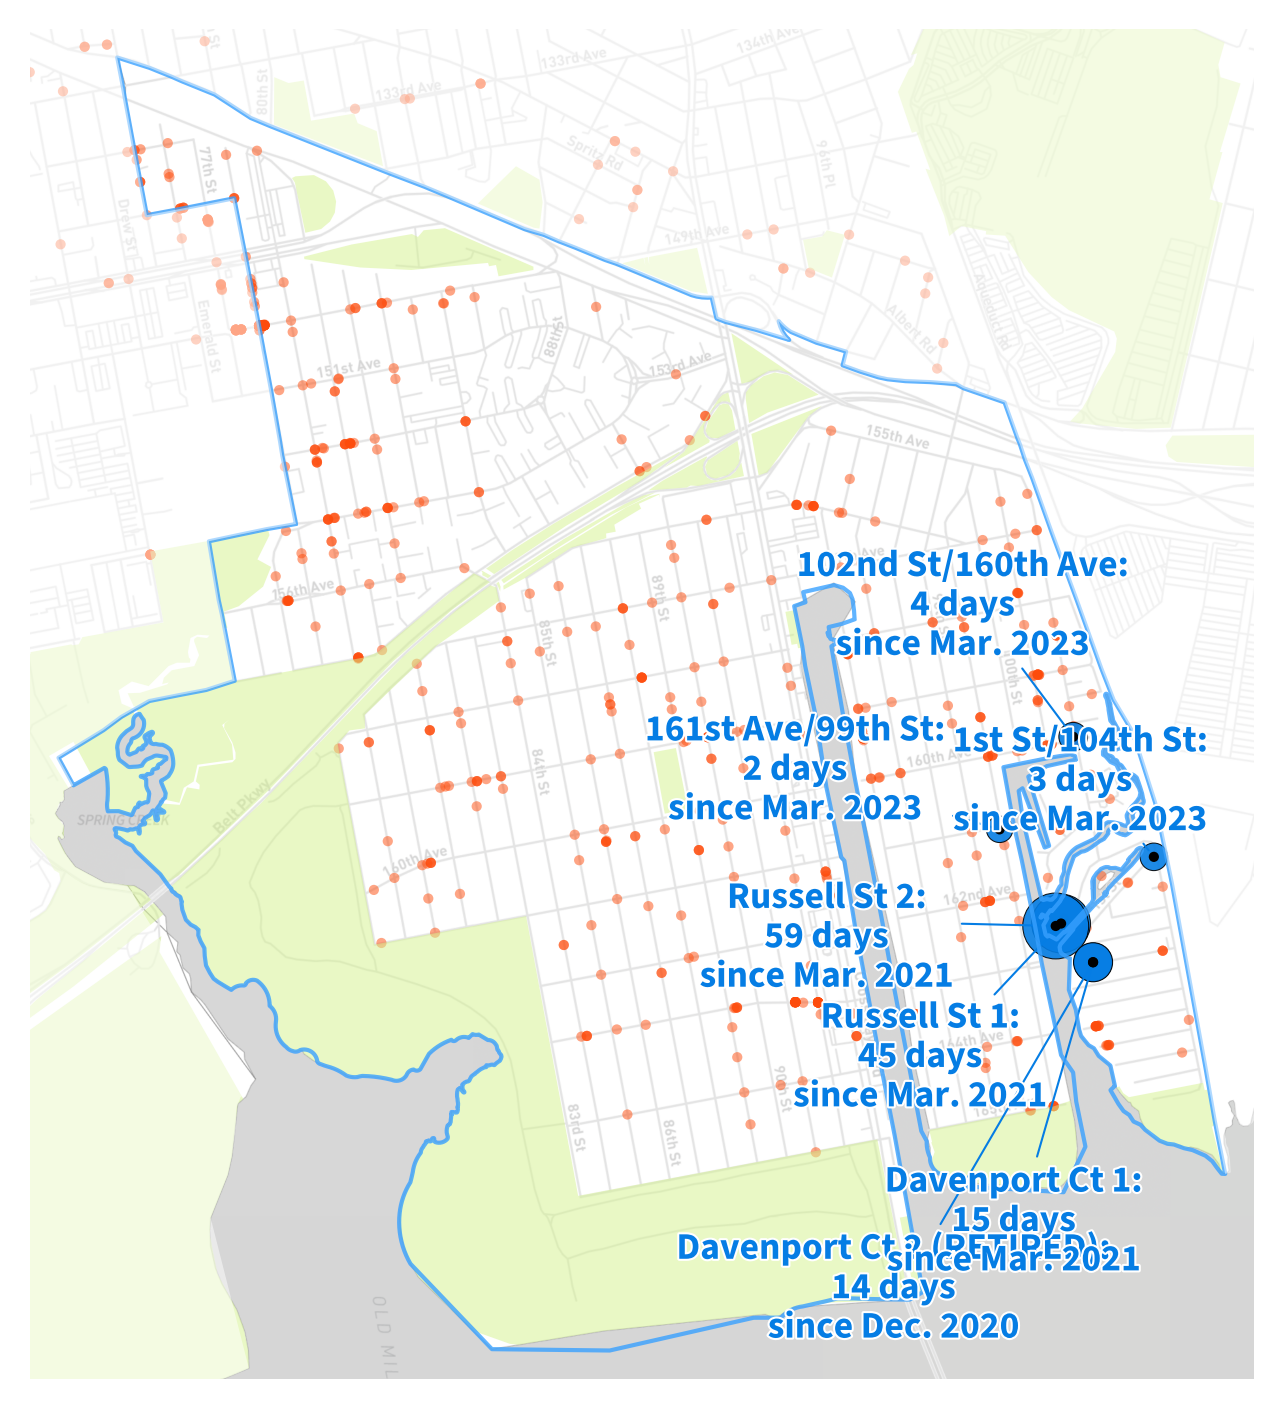

In [108]:
import matplotlib.patheffects as pe
from adjustText import adjust_text
import warnings

warnings.filterwarnings("ignore")

local_cdta = cdta[cdta['CDTALabel'] == cd_name ].to_crs(3857)
other_cdta = cdta[cdta['CDTALabel'] != cd_name ].to_crs(3857)

def prepare_map_data():
    '''
    Map requires very specific data, this function prepares the data for the map
    X many flood event since installation etc, most of the operation are a summary stat.
    '''
    flooded_days = events[ events['Deployment_id'].isin( local_data['deployment_id'].unique()) ].groupby('Deployment_id').size().reset_index().rename(columns={0:'flood_events'})
    
    # First date sensor recorded data, this will be the annotation
    first_record = local_data.groupby('deployment_id').agg({'time_NY':'min','sensor_display_name':'first'})
    first_record['sensor_display_name'] = first_record['sensor_display_name'].str.split(' - ' ).str[1].str.strip()
    # Join Data
    flooded_days_map = local_data.groupby('deployment_id').agg({'lat':'first','lon':'first'}).join( flooded_days.set_index('Deployment_id') ).join( first_record )
    flooded_days_map['time_NY'] = flooded_days_map['time_NY'].dt.strftime('%Y-%m-%d')

    # GeoDataFrame
    flooded_days_map = gpd.GeoDataFrame(flooded_days_map, geometry=gpd.points_from_xy(flooded_days_map.lon, flooded_days_map.lat), crs=4326).to_crs(3857)
    flooded_days_map = flooded_days_map[ ~flooded_days_map['sensor_display_name'].str.contains( 'RETIRE' ) ].copy()
    flooded_days_map.head()

    return flooded_days_map

def plot_map():
    """
    PLOT MAP
    Using CDTA, 311, sensor data, plots the main map for the locla report
    """
    fig,ax = plt.subplots( figsize=(5.225,4.5), dpi=300 )

    # 1. ---------------  BOUNDARIES ------------------
    local_cdta.plot( ax=ax , fc = 'none' , ec = light_blue, alpha = 0.8 , zorder = 10 )
    other_cdta.plot( ax=ax , fc = 'white' , ec = 'none', alpha = 0.5, zorder = 10 )

    # Define plot bounds by local cdta + padding
    pad = 100
    ax.set_xlim( local_cdta['geometry'].bounds.minx.values[0]-pad , local_cdta['geometry'].bounds.maxx.values[0]+pad )
    ax.set_ylim( local_cdta['geometry'].bounds.miny.values[0]-pad , local_cdta['geometry'].bounds.maxy.values[0]+pad )

    # Sensors with Flooding
    with_flooding = flooded_days_map[ flooded_days_map['flood_events'].notnull() ]

    # 2. ------------- WITH FLOODING --------------
    # BLUE CIRCLE
    t = sns.scatterplot(
        x = with_flooding.geometry.x,
        y = with_flooding.geometry.y,
        ax = ax,
        facecolor = "#057de4",
        edgecolor = 'black',
        linewidth = 0.25,
        size = with_flooding[ 'flood_events' ],
        sizes = ( 40 , 250 ),
        alpha = 0.9,
        zorder = 3,
    )

    # BLACK DOT
    flooded_days_map.plot( ax=ax, markersize = 6 , fc = 'black' , ec = 'none' , alpha = 1 , zorder = 10 )
    # 311 orange points
    data_311.to_crs(3857).plot( ax=ax , fc = '#fe4c0c' , ec = 'none', alpha = 0.5 , zorder = 2 , markersize=6 )

    # Annotations
    texts = with_flooding.apply(
        lambda x: ax.annotate( 
            text = f"{x['sensor_display_name']}:\n{int(x['flood_events']) } days\nsince {pd.to_datetime(x['time_NY']).strftime('%b. %Y')}", 
            xy = ( x.geometry.x , x.geometry.y ) , 
            ha = 'center' , va = 'bottom' , 
            xycoords = 'data' ,
            fontsize = 9, fontweight='bold' , color = '#057de4', zorder=100 ,
            path_effects=[pe.withStroke(linewidth=1, foreground="w")]),
        axis = 1
    )

    # 3. ------------- NO FLOODING --------------
    no_flooding = flooded_days_map[ flooded_days_map['flood_events'].isnull() ]
    t2 = no_flooding.plot( ax=ax, markersize=50, fc='none', ec='black', lw=0.5 , zorder=10 )

    circles = [ c for c in t.get_children() if isinstance(c, mpl.collections.PathCollection) ]
    circles2 = [ c for c in t2.get_children() if isinstance(c, mpl.collections.PathCollection) ]

    # Adjust Text so they are not intersecting
    adjust_text(
        texts, 
        x = with_flooding.geometry.x, y = with_flooding.geometry.y,
        autoalign='y',
        force_text = (0.001,0.1), force_objects = (0.001,0.1),
        only_move={'text':'y','point':'y'} , add_objects= circles + circles2, 
        ha='center', precision=0.000000001,
        arrowprops=dict(arrowstyle="-", color="#057de4" , lw=0.5) )

    all_parks = gpd.read_file( os.path.join( report_folder, 'Data', "NYC_Parks_Simplified_FIlled.geojson" ) , crs=4326 )
    all_parks = all_parks.to_crs(3857)
    all_parks.plot( ax=ax , fc = '#d4f28d' , ec = 'none', alpha = 0.5 , zorder = 2 )

    mapbox_url = "https://api.mapbox.com/styles/v1/cankadir/clplqlyio001o01qmewg54ov3/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY2Fua2FkaXIiLCJhIjoiY2pteXplNnEzMHF3YTNrcGx0dGd4MmJrdiJ9.zbhQ39YIdfZufTljuTSl1w"
    ctx.add_basemap( ax, source = mapbox_url, attribution="" )

    ax.axis('off')
    ax.legend([], frameon=False)

    plt.tight_layout(pad=0)

    map1_path = os.path.join( visual_folder , "map1.png" )
    plt.savefig( map1_path , dpi = 150, bbox_inches='tight' ,transparent="True", pad_inches=0);

flooded_days_map = prepare_map_data()

plot_map()

### MAP 2: Inset Map, of NYC

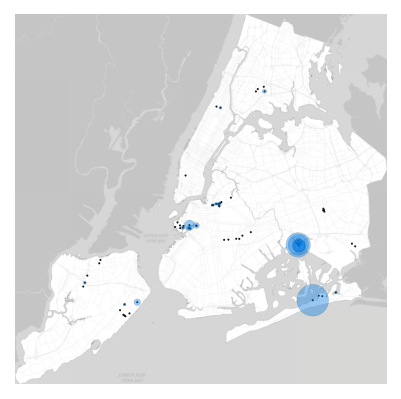

In [109]:
# Prepare data
flooded_days_all = flood_data.groupby( ['deployment_id', pd.Grouper(key='time_NY', freq='1d')] ).agg({'clean_depth_in':'max' }).reset_index()
flooded_days_all = flooded_days_all[ flooded_days_all['clean_depth_in'] > 0.0 ]
flooded_days_all = flooded_days_all.groupby('deployment_id').size().reset_index().rename(columns={0:'flooded_days'})

projected_cdta = cdta.dissolve().to_crs(3857)

sensor_locations = flood_data.groupby('deployment_id').agg({ 'lat':'first', 'lon':'first' }).reset_index()
sensor_locations = gpd.GeoDataFrame( sensor_locations, geometry=gpd.points_from_xy(sensor_locations.lon, sensor_locations.lat), crs=4326 ).to_crs(3857) 
flood_locations = sensor_locations.join( flooded_days_all.set_index('deployment_id'), on='deployment_id' ).dropna( axis=0 )

def plot_insetmap():
    # Plot
    fig,ax = plt.subplots(figsize=(2.475,2.475), dpi=150)

    sensor_locations.plot( ax=ax , fc = 'black' , ec = 'none', alpha = 0.9 , markersize = 1 )
    flood_locations.plot( ax=ax , fc = "#057de4" , ec = 'black', lw=0.1 , alpha = 0.4 , markersize = flood_locations['flooded_days'] * 2 )

    # Define plot bounds by local cdta + padding
    pad = 10
    ax.set_xlim( projected_cdta['geometry'].bounds.minx.values[0]-pad , projected_cdta['geometry'].bounds.maxx.values[0]+pad )
    ax.set_ylim( projected_cdta['geometry'].bounds.miny.values[0]-pad , projected_cdta['geometry'].bounds.maxy.values[0]+pad )

    # Background Map
    mapbox_url = "https://api.mapbox.com/styles/v1/cankadir/clplqlyio001o01qmewg54ov3/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY2Fua2FkaXIiLCJhIjoiY2pteXplNnEzMHF3YTNrcGx0dGd4MmJrdiJ9.zbhQ39YIdfZufTljuTSl1w"
    ctx.add_basemap( ax, source= mapbox_url, attribution="" )
    ax.axis('off')

    plt.tight_layout(pad=0)
    insetmap_path = os.path.join( visual_folder , "insetmap.png" )
    plt.savefig( insetmap_path , dpi = 150, bbox_inches='tight' ,transparent="True", pad_inches=0)

plot_insetmap()

### 311 Heatmap
Pivot sensor and 311 data to monthly and yearly breakdowns.  
Concat 2 datasets and and use different cmaps to plot them under each other. 

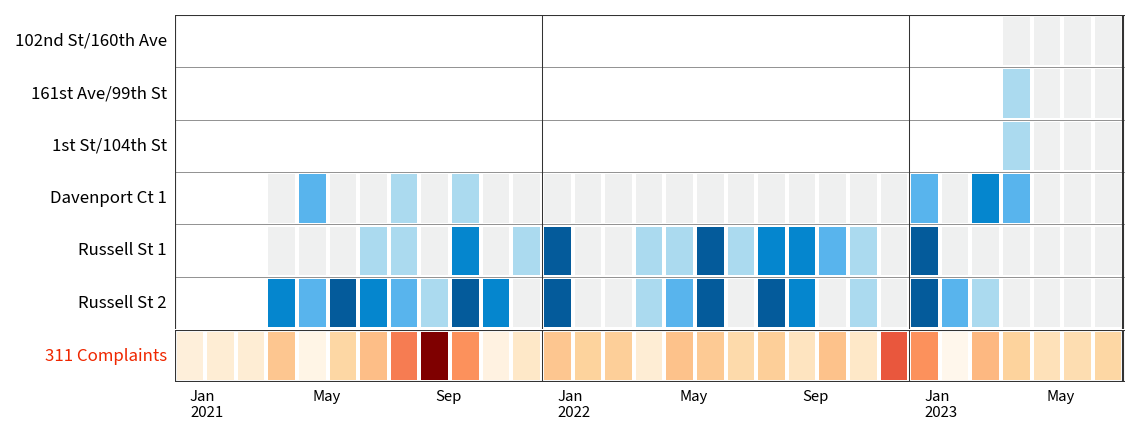

In [110]:
def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

# Parameters
f = '1MS'
custom_ramp = make_Ramp( ['#EFF0F0',"#ABDAEF","#58B4ED", '#0586CE', '#045B9B'] ) 
values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

time_min = local_data['time_NY'].max() - pd.Timedelta( weeks = 6*4 )
local_data['time_NY'] = local_data['time_NY'].dt.tz_localize(None)

def prepare_sensor_data( local_data):
    """Convert sensor data to a pivot table for heatmap"""
    sensors_over_time = local_data.groupby( ['sensor_display_name', pd.Grouper(key='time_NY', freq='1D')] ).agg({'clean_depth_in':'max'}).reset_index()
    sensors_over_time = sensors_over_time[ ~sensors_over_time['sensor_display_name'].str.contains('RET')]

    sensors_over_time_max = sensors_over_time[ sensors_over_time['clean_depth_in'] > 0.0 ]
    sensors_over_time_max = sensors_over_time_max.groupby( ['sensor_display_name', pd.Grouper(key='time_NY', freq=f)] ).agg({'clean_depth_in':'count'}).reset_index()

    all_months = sensors_over_time.groupby( 'sensor_display_name').agg({'time_NY':['min','max']})
    all_months.columns = all_months.columns.droplevel()

    pt = all_months.apply( lambda x: pd.date_range( x['min'], x['max'], freq=f ), axis=1 )\
        .explode().reset_index().rename(columns={0:'time_NY'})\
        .join( sensors_over_time_max.set_index(['sensor_display_name','time_NY']), on=['sensor_display_name','time_NY'] ).fillna(0)\
        .pivot( index='sensor_display_name', columns='time_NY', values='clean_depth_in' )
    return pt

def prepare_311_data( data_311 ):
    data_311['created_date'] = pd.to_datetime(data_311['created_date'])
    filtered_311 = data_311[ data_311['created_date'] < local_data['time_NY'].max() ]

    monthly_311 = filtered_311.groupby( pd.Grouper(key='created_date', freq=f) ).agg({'unique_key':'nunique'}).reset_index().rename(columns={'unique_key':'count'})
    monthly_311['ind'] = '311 Complaints'
    monthly_311 = monthly_311.pivot( index='ind', columns='created_date', values='count' )
    return monthly_311

pt = prepare_sensor_data( local_data )
monthly_311 = prepare_311_data( data_311 )

# join and drop to equalize the ranges
pt = pd.concat( [pt,monthly_311] ).drop( index="311 Complaints" )
pt.index = [i.split(' - ')[1] if '-' in i else i for i in pt.index ]

def plot_combined_heatmap():
    fig, axs = plt.subplots( nrows = 2 , figsize=(7.7,3), height_ratios=[pt.shape[0],1] , sharex=True , dpi=150 )
    # ------------------ Flood VIZ ------------------
    ax = axs[0]
    sns.heatmap(
        pt,
        ax=ax,
        cmap= custom_ramp,
        cbar=False,
        lw=1,
        linecolor='w',
    )


    ax.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False )
    ax.tick_params( axis='y', which='both', left=False , labelsize=9, pad=0.1 )
    ax.set_ylabel('')
    ax.set_xlabel('')

    [ ax.axhline( i+0.495 , color='#333' , lw=0.25 ) for i in ax.get_yticks()]

    # draw frame
    ax.axhline( 0, color='#333', lw=1 )
    ax.axvline( 0, color='#333', lw=1 )
    ax.axvline( ax.get_xticks()[-1]+0.5 , color='#333', lw=1 )

    # ----------------- 311 VIZ -----------------
    ax = axs[1]
    sns.heatmap(
        monthly_311,
        ax=ax,
        cmap= 'OrRd',
        cbar=False,
        lw=1,
        linecolor='w',
    )

    ax.tick_params( axis='y', which='both', left=False, rotation=0 , labelsize=9, pad=0.1 )
    ax.tick_params( axis='x', which='both', bottom=False , pad=0.1 )

    ax.set_ylabel('')
    ax.set_xlabel('')

    # draw frame
    ax.axhline( 0, color='#333', lw=1 )
    ax.axhline( 1, color='#333', lw=1 )
    ax.axvline( 0, color='#333', lw=1 )
    ax.axvline( ax.get_xticks()[-1]+0.5 , color='#333', lw=1 )

    # x-ticks
    ax.set_xticks( np.arange( 0.5 , ax.get_xticks()[-1] , 4 ) )
    xticklabels = [ pd.to_datetime(x.get_text()).strftime('%b') if pd.to_datetime(x.get_text()).strftime('%b') != 'Jan' else f"{pd.to_datetime(x.get_text()).strftime('%b')}\n{pd.to_datetime(x.get_text()).strftime('%Y')}"  for x in ax.get_xticklabels() ]
    ax.set_xticklabels( xticklabels , rotation=0 , ha='left', va='top' , fontsize=8 )
    ax.set_yticklabels( ['311 Complaints'], color='#Ef2700' )

    [ axs[1].axvline(ticks-0.5, color='#333', lw=0.5 ) for labels,ticks in zip(ax.get_xticklabels(),ax.get_xticks()) if "Jan" in labels.get_text() ]
    [ axs[0].axvline(ticks-0.5, color='#333', lw=0.5 ) for labels,ticks in zip(ax.get_xticklabels(),ax.get_xticks()) if "Jan" in labels.get_text() ]

    ax.set_xlim( ax.get_xlim()[0] , ax.get_xlim()[1]+0.05 )
    plt.tight_layout( h_pad=0.025 )

    heatmap_path = os.path.join( visual_folder , "heatmap_311.png" )
    plt.savefig( heatmap_path , bbox_inches='tight' ,transparent="True", pad_inches=0)
    
plot_combined_heatmap()

6.0 52


C:\Users\cansu\AppData\Local\Temp\ipykernel_12764\2959595545.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fake_data = pd.concat( [fake_data, pd.DataFrame([None]) ] )
C:\Users\cansu\AppData\Local\Temp\ipykernel_12764\2959595545.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout( pad=0 )


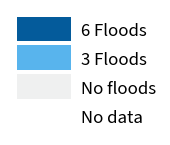

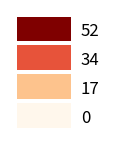

In [39]:
max_flooded_day = pt.max().max()
max_complaint = monthly_311.max().max()

print( max_flooded_day , max_complaint ) 

fig,ax = plt.subplots( figsize=(0.5,1), dpi=150 )

fake_data = pd.DataFrame( np.linspace(  max_flooded_day,0, 3 ) )
fake_data = pd.concat( [fake_data, pd.DataFrame([None]) ] )

sns.heatmap(
    fake_data,
    cmap = custom_ramp,
    cbar = False,
    lw = 1,
    linecolor = 'w',
    ax=ax
)

ax.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False )
ax.tick_params( axis='y', which='both', left=False, labelleft=False, labelright=True , labelsize=9, pad=0.1, rotation=0 )

ax.set_yticklabels( [ f"{int(max_flooded_day)} Floods", f"{int(max_flooded_day/2)} Floods" , "No floods", "No data" ])
fig.tight_layout( pad=0 )
fig.savefig( os.path.join( visual_folder , "legend_floods.png" ) , bbox_inches='tight' ,transparent="True", pad_inches=0)


fig,ax = plt.subplots( figsize=(0.5,1), dpi=150 )

fake_data = pd.DataFrame( np.linspace(  max_complaint , 0, 4 ) )

sns.heatmap(
    data = fake_data,
    cmap = 'OrRd' ,
    cbar = False,
    lw = 1,
    linecolor = 'w',
    ax=ax
)

ax.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False )
ax.tick_params( axis='y', which='both', left=False, labelleft=False, labelright=True , labelsize=9, pad=0.1, rotation=0 )

ax.set_yticklabels( [str(int(i)) for i in np.linspace(  max_complaint , 0 , 4 )]  )
fig.savefig( os.path.join( visual_folder , "legend_311.png" ) , bbox_inches='tight' ,transparent="True", pad_inches=0)

## Flood Events and Highlighted Events

#### Highlighted events
Using NYU's metadata to get hightlighted events and sensor

In [112]:
# "C:\Users\cansu\Dropbox\FloodNet_Report_Automation\DATA\Neighborhood Flood Reports Sensor List Metadata.xlsx"
sensor_metadata = r"C:\Users\cansu\Dropbox\FloodNet_Report_Automation\DATA\Neighborhood Flood Reports Sensor List Metadata.xlsx"
sensor_metadata = pd.read_excel( sensor_metadata , sheet_name='Sensor list + metadata' )

highlighted_sensor = sensor_metadata[ ( sensor_metadata['Highlighted Event Start - Nov 2023'].notnull() ) & ( sensor_metadata['neighborhood_label'] == cd_name ) ]
highlighted_sensor.head()

,sensor_display_name,sensor_address_borough,neighborhood_label,date_deployed,deployment_id,Highlighted Event Start - Nov 2023,Highlighted Event End - Nov 2023,Event type (Coastal/Pluvial),Highlighted event name,weather_station,tidal_gauge
2,Q - Russell St 1,Queens,Howard Beach-Lindenwood,2021-03-05,duly_pro_vervet,2022-09-07 04:37:00+00:00,2022-09-12 21:03:00+00:00,Coastal,NaN,NaN,usgs-tidal-01311850


2022-09-07 00:37:00 2022-09-12 17:03:00


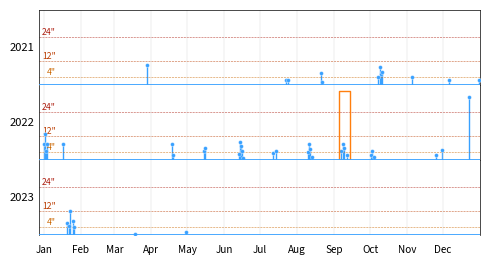

In [127]:

grid_colors = ['#ca6702','#bb3e03','#ae2012']
values = ['Minor Flood', 'Moderate Flood', 'Major Flood']

def plot_stacked_timeline( local_data , f="1D"):
    """
    Stacks Years and creates a lollipop chart for each year for the highlighted sensor
    Formatting frames around the charts are taking a long portion of the code
    To be able to match the x-axis, every years data is converted to year 1900-month-day
    """

    filtered_data = local_data.dropna( subset=['sensor_display_name'] ,axis=0 )
    single_sensor = filtered_data[ filtered_data['deployment_id'] == highlighted_sensor['deployment_id'].values[0] ].copy()
    single_sensor_1h = single_sensor.groupby(pd.Grouper(key='time_NY', freq=f)).agg({'clean_depth_in':'max'}).reset_index()

    single_sensor_1h['date'] = single_sensor_1h['time_NY'].dt.date
    single_sensor_1h['hour'] = single_sensor_1h['time_NY'].dt.hour
    single_sensor_1h['year'] = single_sensor_1h['time_NY'].dt.year

    single_sensor_1h['flat_date'] = single_sensor_1h['time_NY'].dt.strftime('1900-%m-%d %H:%M:%S')
    single_sensor_1h['flat_date'] = pd.to_datetime( single_sensor_1h['flat_date'] )
    single_sensor_1h['flat_date_end'] = single_sensor_1h['flat_date'] + pd.Timedelta( f )

    fig,axs = plt.subplots( nrows = single_sensor_1h[single_sensor_1h['clean_depth_in'] > 0]['year'].nunique() , sharex=True, sharey=True, figsize = (5,2.75) )

    for i,year in enumerate( single_sensor_1h[single_sensor_1h['clean_depth_in'] > 0]['year'].unique() ):
        ax = axs[i]
        single_sensor_1h_year = single_sensor_1h[ single_sensor_1h['year'] == year ]

        # lollipop stems
        ax.vlines( ymax=single_sensor_1h_year['clean_depth_in'], ymin=0, x=single_sensor_1h_year['flat_date'] , alpha=1 , lw=1, color='#39a1ff' )

        # lollipop heads
        single_sensor_1h_year_above = single_sensor_1h_year[ single_sensor_1h_year['clean_depth_in'] > 0 ]
        ax.scatter( y=single_sensor_1h_year_above['clean_depth_in'], x=single_sensor_1h_year_above['flat_date'], s=8 , marker='o', lw=0.25 ,fc='#39a1ff' ,ec='w', zorder=5 )

        sns.despine( ax=ax, bottom=True, right=False )
        ax.set_ylim( 0, single_sensor_1h['clean_depth_in'].max() + 6 )
        ax.set_ylabel( year, rotation=0 , labelpad=3, fontsize = 9 , ha='right', va='center' )

        # every month: format y-axis as %b %d
        ax.xaxis.set_major_formatter( mdates.DateFormatter('%b') )
        ax.xaxis.set_major_locator( mdates.MonthLocator() )

        ax.set_xlim( pd.to_datetime('28-12-1899 00:00:00',dayfirst=True) , pd.to_datetime('31-12-1900 23:59:59',dayfirst=True) )
        ax.tick_params(axis='y', which='both', left=False, labelleft=False )
        ax.tick_params( axis='x' , labelsize=8 , bottom=False )

        # Horizontal grid (2 12 24  )
        [ ax.axhline(t, ls='--', lw=0.4, alpha=0.8, color=grid_colors[n]) for n,t in enumerate([4,12,24]) ]
        ax.axhline( 0 , ls='-', lw=2, alpha=1, color='#39a1ff', zorder=200)
        [ ax.annotate( f'{t}"', xy=( pd.to_datetime('01-01-1900')+pd.Timedelta(days=10),t) ,color=grid_colors[n], va='bottom', ha='right', fontsize=7 ) for n,t in enumerate([4,12,24]) ]
        # vertical grid
        [ ax.axvline( pd.to_datetime( f'{i}-01-1900' ), color="#cecece", lw=0.25, alpha=1 ) for i in range(1,13)]

        # set spine lw 
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0.5)

        if i==0:
            ax.spines['top'].set_visible(True)
            ax.spines['top'].set_linewidth(0.5)

        event_startdate = highlighted_sensor['Highlighted Event Start - Nov 2023'].values[0]
        event_startdate = pd.to_datetime( event_startdate )
        event_startdate = event_startdate.tz_convert('America/New_York').tz_localize(None)
        
        event_enddate = highlighted_sensor['Highlighted Event End - Nov 2023'].values[0]
        event_enddate = pd.to_datetime( event_enddate )
        event_enddate = event_enddate.tz_convert('America/New_York').tz_localize(None)

        if year == event_startdate.year :  
            
            print( event_startdate , event_enddate )
            event_converted_startdate = pd.to_datetime( f'1900-{event_startdate.month}-{event_startdate.day} {event_startdate.hour}:00:00' )
            event_converted_enddate = pd.to_datetime( f'1900-{event_enddate.month}-{event_enddate.day} {event_enddate.hour}:00:00' )
            
            event_midpoint = event_converted_startdate + ( event_converted_enddate - event_converted_startdate ) / 2

            event_converted_startdate = event_midpoint - pd.Timedelta( days = 4.5 )
            event_converted_enddate = event_midpoint + pd.Timedelta( days = 4.5 )

            # make span with vmin and vmax
            ax.fill_between( [ event_converted_startdate , event_converted_enddate ] , 0 , single_sensor_1h['clean_depth_in'].max() + 3 , ec='#ff7f0e', fc='none', alpha=1 , zorder=150, capstyle='round', joinstyle='round' )
        
    fig.tight_layout( w_pad=0.005, h_pad=0 )
    fig.savefig( os.path.join( visual_folder , "flood_timeline.png" ) , transparent="True" , bbox_inches='tight', pad_inches=0.02 , dpi=300 )

plot_stacked_timeline( local_data , '1D')

#### Pop-Up Chart

In [124]:
event_startdate = highlighted_sensor['Highlighted Event Start - Nov 2023'].values[0]
event_startdate = pd.to_datetime( event_startdate )

event_enddate = highlighted_sensor['Highlighted Event End - Nov 2023'].values[0]
event_enddate = pd.to_datetime( event_enddate )

event_name = highlighted_sensor['Highlighted event name'].values[0]

flood_type = highlighted_sensor['Event type (Coastal/Pluvial)'].values[0]

event_startdate , event_enddate, flood_type

(Timestamp('2022-09-07 04:37:00+0000', tz='UTC'),
 Timestamp('2022-09-12 21:03:00+0000', tz='UTC'),
 'Coastal')

In [125]:
def get_noaa_tidal_info( station , time_min , time_max ):
    
    time_min = pd.to_datetime(time_min,utc=True).tz_convert("America/New_York").strftime('%Y%m%d %H:%M')
    time_max = pd.to_datetime(time_max,utc=True).tz_convert("America/New_York").strftime('%Y%m%d %H:%M')

    url = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={ time_min }&end_date={ time_max }&station={station.split("-")[-1]}&product=water_level&datum=NAVD&time_zone=gmt&units=english&application=DataAPI_Sample&format=json'
    r = requests.get(url)

    data = r.json()['data']
    df = pd.DataFrame( data )
    df['time_NY'] = pd.to_datetime(df['t'], utc=True ).dt.tz_convert('US/Eastern').dt.tz_localize(None)
    df = df.drop(['q','f'],axis=1)
    df['v'] = pd.to_numeric( df['v'] )
    return df

def get_usgs_tidal_info( station , time_min , time_max ):
    
    time_min = time_min.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    time_max = time_max.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

    url = f'https://waterservices.usgs.gov/nwis/iv/?format=json&sites={station.split("-")[-1]}&parameterCd=62620&siteStatus=all&startDT={time_min}&endDT={time_max}'

    df = requests.get(url).json()
    tidal = pd.DataFrame( df['value']['timeSeries'][0]['values'][0]['value'] )
    tidal['dateTime'] = pd.to_datetime( tidal['dateTime'] )
    tidal['time_NY'] = tidal['dateTime'].dt.tz_localize(None)
    tidal['value'] = pd.to_numeric( tidal['value'] )
    tidal.columns = tidal.columns.str.replace('value','v')
    tidal = tidal[['time_NY', 'dateTime' ,'v']]

    # !!! Add NAV88 to offset !!!
    
    # Not sure if this is necessary
    tidal = tidal[ 
        (tidal['time_NY'] > pd.to_datetime(time_min,utc=True).tz_convert('America/New_York').tz_localize(None)) & 
        (tidal['time_NY'] < pd.to_datetime(time_max,utc=True).tz_convert('America/New_York').tz_localize(None))]

    return tidal.set_index('time_NY')

def get_rain_data( time_min , time_max, station_code ):
    import io
    # Prapare parameters
    time_min = pd.to_datetime(time_min,utc=True).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    time_max = pd.to_datetime(time_max,utc=True).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    timerange = f"{time_min}/{time_max}"
    payload = "variables[]=tair@degC&variables[]=tslo@degC&variables[]=relh@percent&variables[]=precip:incremental@mm&variables[]=precip@mm&variables[]=precip_local@mm&variables[]=precip_total@mm&variables[]=precip_max_intensity@mm/min&variables[]=winds_sonic@m/s&variables[]=srad@W/m^2&variables[]=pres@millibars&variables[]=snow_depth@mm&variables[]=lat@degrees&variables[]=lon@degrees"

    # query and df
    url = f'https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/{timerange}?{payload}'
    response = requests.get(url)
    df = pd.read_csv(io.StringIO( response.content.decode('utf-8')))

    # filter to one station
    station_code = station_code.split('-')[-1]
    df = df[ df['station'] == station_code.upper() ]

    # convert to datetime and format
    df['time_NY'] = pd.to_datetime(df['datetime']).dt.tz_convert('America/New_York').dt.tz_localize(None)
    df = df[['datetime', 'station','time_NY','precip_max_intensity [mm/min]']]
    df.columns = df.columns.str.replace(' [mm/min]','_mmmin')

    # convert mm/min to in/min
    df['precip_max_intensity_inmin'] = df['precip_max_intensity_mmmin'] * 0.0393701

    return df

def get_background_data( flood_type ):

    if flood_type == 'Coastal':

        # usgs station API
        station = highlighted_sensor['tidal_gauge'].values[0]
        if station.split('-')[0] == 'usgs':
            df = get_usgs_tidal_info( station , event_startdate , event_enddate )
        else:
            df = get_noaa_tidal_info( station , event_startdate , event_enddate )

    if flood_type == 'Pluvial':
        df = get_rain_data( event_startdate , event_enddate, highlighted_sensor['weather_station'].values[0] )


    return df

# Add NAVD offsets
background_data = get_background_data( flood_type )
background_data.head(3)

,dateTime,v
time_NY,,
2022-09-07 00:42:00,2022-09-07 00:42:00-05:00,-1.16
2022-09-07 00:48:00,2022-09-07 00:48:00-05:00,-1.03
2022-09-07 00:54:00,2022-09-07 00:54:00-05:00,-0.87


Coastal


C:\Users\cansu\AppData\Local\Temp\ipykernel_12764\58134096.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels( [f'{i:.0f}"' for i in ax.get_yticks()] , color='#2093f2' )


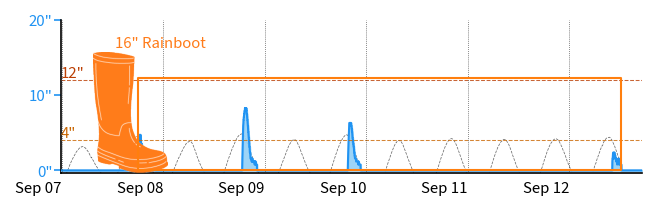

In [123]:
# single sensor, hightlighted event
single_sensor = flood_data[ flood_data['deployment_id'] == highlighted_sensor['deployment_id'].values[0] ].copy()

# Add some padding to the plot
event_start_time_NY =  event_startdate.tz_convert('America/New_York').tz_localize(None) - pd.Timedelta( hours = 0.75 )
event_end_time_NY =  event_enddate.tz_convert('America/New_York').tz_localize(None) + pd.Timedelta( hours = 0.25 )

# Filter data
single_sensor['time_NY'] = single_sensor['time_NY'].dt.tz_localize(None)
filtered_data = single_sensor[ (single_sensor['time_NY'] >= event_start_time_NY ) & (single_sensor['time_NY'] <= event_end_time_NY ) ].copy()
filtered_data['time_NY'] = pd.to_datetime(filtered_data['time_NY'])
fig,ax = plt.subplots( figsize=(5,1.5) , dpi=150 )
sns.despine(left=False, ax=ax )

# PLOT
ax.plot( filtered_data['time_NY'], filtered_data['clean_depth_in'], lw=1, color='#2093f2' , zorder=10 , label='Flooding' )
ax.fill_between( filtered_data['time_NY'], filtered_data['clean_depth_in'], color="#92d0f7", alpha=0.9 , zorder=9 )

# hlines on x ticks similar to grid
[ ax.axvline( t , color='#333', lw=0.35, ls=":", zorder = 14 ) for t in ax.get_xticks() ]

# Orange Box from event start to event end, frm y=0 to y=18
ax.fill_between( [filtered_data[ filtered_data['clean_depth_in'] > 0 ]['time_NY'].min() , filtered_data[ filtered_data['clean_depth_in'] > 0 ]['time_NY'].max()] , 0 , filtered_data['clean_depth_in'].max() + 4 , ec='#ff7f0e', fc='none', alpha=1 , zorder=150, capstyle='round', joinstyle='round' )

# Make sure the y-axis is always higher than 18"
ax.set_xlim( event_start_time_NY , event_end_time_NY )
if filtered_data['clean_depth_in'].max() + 6 > 20:
    ax.set_ylim( -0.3 , filtered_data['clean_depth_in'].max() + 6 )
else:
    ax.set_ylim( -0.3 , 20 )

# ---------- RAIN FALL or TIDE ---------------
if flood_type == 'Pluvial':

    ax2 = ax.twinx()
    # filter backgorund data
    background_data_filtered = background_data[ (background_data['time_NY'] >= event_start_time_NY ) & (background_data['time_NY'] <= event_end_time_NY ) ]
    background_data_filtered = background_data_filtered.groupby( pd.Grouper(key='time_NY', freq='10min') ).agg({'precip_hrly':'max'}).reset_index()
    ax2.bar( background_data_filtered['time_NY'], background_data_filtered['precip_hrly'] , width=0.0015 , fc='#333', ec='none', alpha=0.6 , zorder=5, label='Hourly Precipitaion' )
    ax2.set_xlim( event_start_time_NY , event_end_time_NY )
    
    for i in ['left','top','bottom']: ax2.spines[i].set_visible(False)
    ax2.yaxis.tick_right()
    ax2.tick_params(axis='y',which='both',left=False, labelleft=False , labelsize=8 )
    
    # # add " to highset y-tick
    ax2.set_yticklabels( [f'{t}"\nHrly\nPrec.' if t==ax2.get_yticks()[-1] else f'{t}"' for t in ax2.get_yticks()] )
    ax2.set_ylim( 0 , background_data['precip_hrly'].max() * 1.2 )

    ax.spines['left'].set_linewidth(0.5)
    ax2.spines['right'].set_linewidth(0.5)

    ax2.set_zorder(3)
    ax2.set_facecolor("none")

else:
    print('Coastal')
    background_data.plot( ax=ax , y='v' , lw=0.35 , ls='--', color='#333', alpha=0.75 , legend=False )
    ax.set_xlabel('')

# Flood Measures
grid_colors = ['#ca6702','#bb3e03','#ae2012']
[ ax.axhline(t, ls='--', lw=0.5, alpha=0.8, color=grid_colors[n] , zorder=11) for n,t in enumerate([4,12,24])  ]
[ ax.annotate(f'{t}"', xy=( filtered_data['time_NY'].min() , t) ,color=grid_colors[n], va='bottom', ha='left', fontsize=8 , zorder=11 ) for n,t in enumerate([4,12,24]) ]

# Ticks formatting
ax.tick_params(axis='y', which='both', left=True, labelleft=True , labelsize=8 , pad=0.5, color='#2093f2' )
ax.set_yticklabels( [f'{i:.0f}"' for i in ax.get_yticks()] , color='#2093f2' )

# if time on plot is less than a day
if filtered_data['time_NY'].max() - filtered_data['time_NY'].min() < pd.Timedelta( days = 1 ):
    ax.xaxis.set_major_locator( mdates.HourLocator(interval=1) )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
    ax.tick_params( axis='x', labelsize=8 , pad=0.5, bottom=False )
else:
    ax.xaxis.set_major_locator( mdates.DayLocator(interval=1) )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params( axis='x', labelsize=8 , pad=0.5, bottom=False , rotation=0 )

# ------------- RAINBOOT -----------------
def get_rainboot():
    # A new axis is formed -> height of the axis is plot height / flood height, to match 16
    rainboot = r"C:\Users\cansu\Dropbox\FloodNet_Report_Automation\DATA\rainboot_16inch_orange-01.png"
    rainboot = plt.imread( rainboot , format='png' )
    height_ratio = 16 / (ax.get_ylim()[1] - ax.get_ylim()[0])
    axin = ax.inset_axes( [0.02 , 0 , 0.2 , height_ratio ]  )    # create new inset axes in data coordinates
    axin.imshow( rainboot , zorder=100 )
    axin.axis('off')
    axin.set_zorder(100)
    axin.set_facecolor("none")
    ax.annotate( '16" Rainboot' , xy=( 0.25 , height_ratio + 0.01 ), xycoords='axes fraction' , ha='right', va='bottom', fontsize=8 , color='#FF7C1A' )
get_rainboot()

# order plots
ax.set_zorder(2)
ax.set_facecolor("none")

fig.savefig( os.path.join( visual_folder , "flood_timeline_zoom.png" ) ,bbox_inches='tight', transparent="True" , pad_inches=0 , dpi=150 )

## Get Photos From MyCoast

In [139]:
# check if myCoast_photos folder exists in the visual folder
if not os.path.exists( os.path.join( visual_folder , 'myCoast_photos' ) ):
    os.makedirs( os.path.join( visual_folder , 'myCoast_photos' ) )
photos_folder = os.path.join( visual_folder , 'myCoast_photos' )

url = 'https://mycoast.org/wp-admin/admin-ajax.php?action=mapp_query& \
    query[category_name]=highwater&query[tag__and][]=121& \
    url[href]=https://mycoast.org/ny/flood-watch&url[search]='

headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/116.0'}

response = requests.get(url, headers=headers)
data = response.json()
data = data['data']

myCoast_data = pd.DataFrame( data['pois'] )

print( myCoast_data.shape[0] , 'data points found' )
myCoast_data.head()

1410 data points found


,address,body,data,email,iconid,images,kml,name,oid,otype,point,poly,props,title,type,url,viewport
0,"40.5763172463, -73.8582246418",,None,None,highwater.svg,None,None,None,142091,post,"{'lat': '40.5763172463', 'lng': '-73.8582246418'}",None,"{'geo_locality': '', 'geo_administrative_area_...",40.5763172463 -73.8582246418,None,https://mycoast.org/reports/142091,None
1,"40.65334759246563, -73.83004722028804",,None,None,highwater.svg,None,None,None,134073,post,"{'lat': '40.65334759246563', 'lng': '-73.83004...",None,"{'geo_locality': '', 'geo_administrative_area_...",40.65334759246563 -73.83004722028804,None,https://mycoast.org/reports/134073,None
2,"40.8059335163, -72.6390809542",,None,None,highwater.svg,None,None,None,129855,post,"{'lat': '40.8059335163', 'lng': '-72.6390809542'}",None,"{'geo_locality': 'Westhampton Beach', 'geo_adm...",40.8059335163 -72.6390809542,None,https://mycoast.org/reports/129855,None
3,"40.657703438427546, -73.83808084475532",,None,None,highwater.svg,None,None,None,128901,post,"{'lat': '40.657703438427546', 'lng': '-73.8380...",None,"{'geo_locality': '', 'geo_administrative_area_...",40.657703438427546 -73.83808084475532,None,https://mycoast.org/reports/128901,None
4,"40.9187036, -73.1770703",,None,None,highwater.svg,None,None,None,128581,post,"{'lat': '40.9187036', 'lng': '-73.1770703'}",None,"{'geo_locality': 'Nissequogue', 'geo_administr...",40.9187036 -73.1770703,None,https://mycoast.org/reports/128581,None


In [142]:
myCoast_data['photo_date'] = myCoast_data['props'].apply( lambda x: x['photo_date'] )
myCoast_data['photo_time'] = myCoast_data['props'].apply( lambda x: x['photo_time'] )
myCoast_data['pics'] = myCoast_data['props'].apply( lambda x: x['ourPics'] )

myCoast_data['lat'] = myCoast_data['point'].apply( lambda x: x['lat'] )
myCoast_data['lon'] = myCoast_data['point'].apply( lambda x: x['lng'] )
myCoast_data['pic_urls'] = myCoast_data['pics'].apply( lambda x: [i.split('/></a>')[0].replace("'","") for i in x.split('src=') if 'https' in i] )
myCoast_data['pic_count'] = myCoast_data['pic_urls'].apply( lambda x: len(x) )
myCoast_data[[ 'url','images','photo_date','photo_time','pics','lat','lon','pic_urls', 'pic_count' ]]

,url,images,photo_date,photo_time,pics,lat,lon,pic_urls,pic_count
0,https://mycoast.org/reports/142091,None,2023-11-27,8:14 am,<div class='search-result-single-image-wrapper...,40.5763172463,-73.8582246418,[https://report-images.nyc3.digitaloceanspaces...,3
1,https://mycoast.org/reports/134073,None,2023-10-30,10:00 am,<div class='search-result-single-image-wrapper...,40.65334759246563,-73.83004722028804,[https://report-images.nyc3.digitaloceanspaces...,1
2,https://mycoast.org/reports/129855,None,2023-10-16,10:17 am,<div class='search-result-single-image-wrapper...,40.8059335163,-72.6390809542,[https://report-images.nyc3.digitaloceanspaces...,1
3,https://mycoast.org/reports/128901,None,2023-10-01,10:20 am,<div class='search-result-single-image-wrapper...,40.657703438427546,-73.83808084475532,[https://report-images.nyc3.digitaloceanspaces...,1
4,https://mycoast.org/reports/128581,None,2023-09-30,12:57 pm,<div class='search-result-single-image-wrapper...,40.9187036,-73.1770703,[https://report-images.nyc3.digitaloceanspaces...,1
...,...,...,...,...,...,...,...,...,...
1405,https://mycoast.org/reports/134507,None,2018-09-10,09:50 am,<div class='search-result-single-image-wrapper...,40.6534008,-73.8302549,[https://report-images.nyc3.digitaloceanspaces...,2
1406,https://mycoast.org/reports/136642,None,2016-02-09,05:00 pm,<div class='search-result-single-image-wrapper...,40.595873097,-73.771498369,[https://report-images.nyc3.digitaloceanspaces...,1
1407,https://mycoast.org/reports/102633,None,2016-02-09,03:43 pm,<div class='search-result-single-image-wrapper...,40.65720146993478,-73.84323120117188,[https://report-images.nyc3.digitaloceanspaces...,1
1408,https://mycoast.org/reports/20384,None,2015-09-30,10:51 am,<div class='search-result-single-image-wrapper...,40.7520353,-74.00785960000002,[https://report-images.nyc3.digitaloceanspaces...,1


In [159]:
myCoast_geo = gpd.GeoDataFrame( myCoast_data, geometry=gpd.points_from_xy(myCoast_data.lon, myCoast_data.lat), crs=4326 )

dist = 0.5
myCoast_photos_count = 0
while myCoast_photos_count < 3 :
    
    dist = dist + 0.1
    local_cdta['buffer_geometry'] = local_cdta['geometry'].to_crs(2263).buffer( 5280*dist ).to_crs(4326)
    buffer_cdta = local_cdta.set_geometry( 'buffer_geometry' )

    myCoast_cdta = myCoast_geo.sjoin( buffer_cdta )
    myCoast_photos_count = myCoast_cdta['pic_count'].sum()
    # print( dist , myCoast_photos_count , 'photos found' )

myCoast_cdta_wpics = myCoast_cdta[ myCoast_cdta['pic_count'] > 0 ].drop(['title','type','viewport','index_right','geometry_right'],axis=1).copy()
myCoast_cdta_wpics

,address,body,data,email,iconid,images,kml,name,oid,otype,point,poly,props,url,photo_date,photo_time,pics,lat,lon,pic_urls,pic_count,geometry_left,CDTAName,CDTALabel
36,"40.6493612, -74.0095916",,None,None,highwater.svg,None,None,None,115938,post,"{'lat': '40.6493612', 'lng': '-74.0095916'}",None,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/115938,2023-05-01,08:59 am,<div class='search-result-single-image-wrapper...,40.6493612,-74.0095916,[https://report-images.nyc3.digitaloceanspaces...,1,POINT (-74.00959 40.64936),BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens
1409,"40.6759445259, -74.0086725961",,None,None,highwater.svg,None,None,None,113708,post,"{'lat': '40.6759445259', 'lng': '-74.0086725961'}",None,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/113708,2012-10-22,7:30 pm,<div class='search-result-single-image-wrapper...,40.6759445259,-74.0086725961,[https://report-images.nyc3.digitaloceanspaces...,2,POINT (-74.00867 40.67594),BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens


In [177]:
import lxml
import lxml.html

def extract_images( url ):
    response = requests.get(url, headers=headers)
    tree = lxml.html.fromstring(response.content)
    img = tree.xpath('//img')

    sources = []
    for i in img:
        source = i.attrib['src'] 
        if ("logo" not in source) and ("footer" not in source) :
            sources.append(source)
    return sources

def extract_comments( url):
    # get text or h content in div with class "post_author_comment"
    response = requests.get(url, headers=headers)
    tree = lxml.html.fromstring(response.content)
    comments = tree.xpath('//div[@class="post-author-comment"]//h6')
    comments = comments[0].text_content().replace('"','')
    return comments

myCoast_info = []
for i,r in myCoast_cdta_wpics.iterrows():
    url = r['url']
    picture_links = extract_images( url ) 
    comments = extract_comments( url ) 
    myCoast_info.append( [url,comments, picture_links] )
    
myCoast_info = pd.DataFrame( myCoast_info , columns=['url','comments','picture_links'] )
myCoast_info['picture_count'] = myCoast_info['picture_links'].apply( lambda x: len(x) )

myCoast_info

,url,comments,picture_links,picture_count
0,https://mycoast.org/reports/115938,It's not even raining today. The rain water wa...,[https://i0.wp.com/report-images.nyc3.digitalo...,1
1,https://mycoast.org/reports/113708,I’m not sure of the date or time. I do know th...,[https://i0.wp.com/report-images.nyc3.digitalo...,2


https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/05/01162226/subway-flood-scaled.jpg?h=800
https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/04/10092856/15398d64610490cc2682469ee5583f7c0c0fa0f1.jpg?h=550
https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/04/10092859/343c358aaa171e60d970e6a48cbd63439303361f.jpg?h=550
[600.0, 369.45454545454544, 369.45454545454544]
[600.0, 738.9090909090909]
C:\Users\cansu\Dropbox\FloodNet_Report_Automation\WEB_LAYOUT\assets\IMG


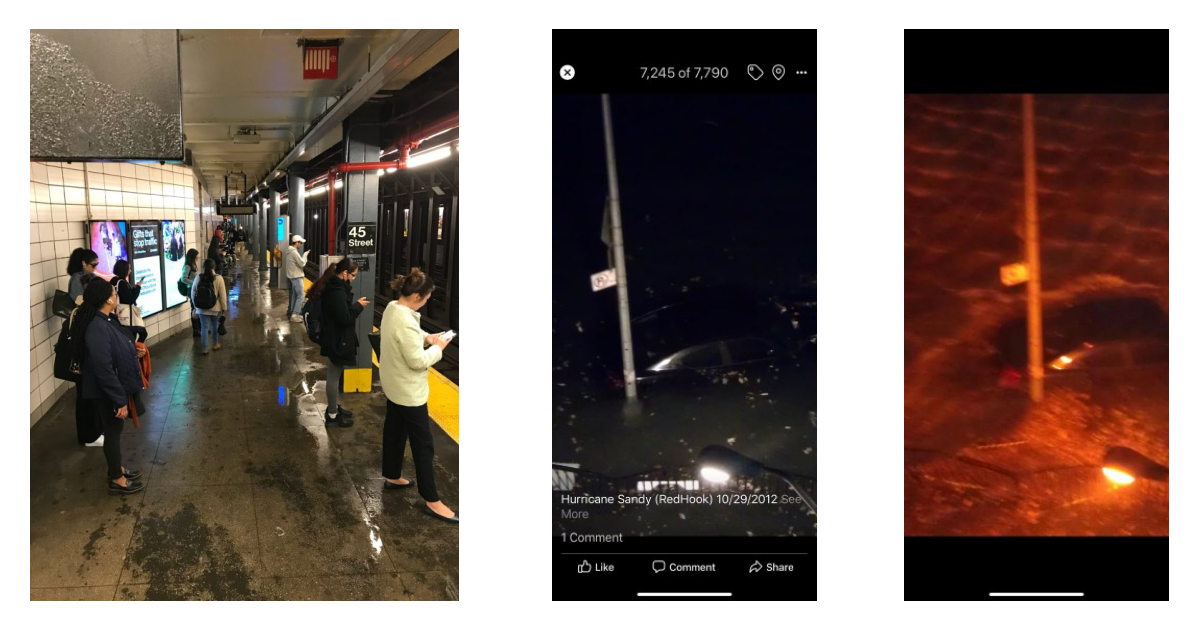

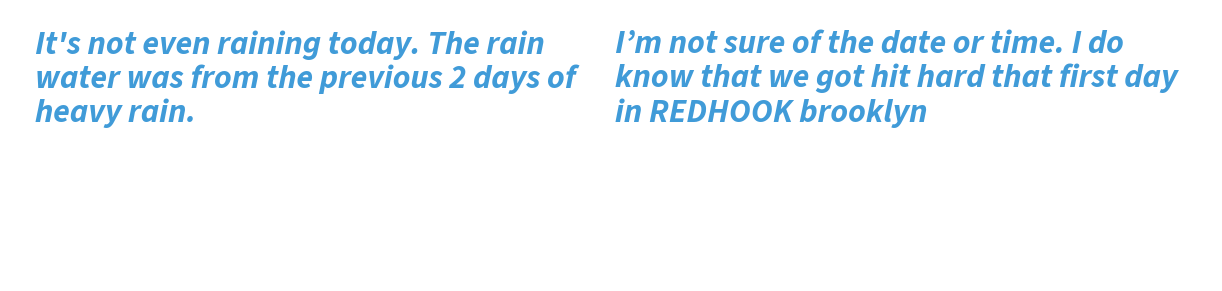

In [282]:
# plot images using matplotlib using links
from imageio.v2 import imread

imgs = []
sizes_widths = []
sizes_heights = []
for i,r in myCoast_info.iterrows():

    for link in r['picture_links']:
        print( link )
        a = imread( link )
        imgs.append( a )

        sizes_widths.append( (a.shape[1]) )
        sizes_heights.append( (a.shape[0]) )

max_height = max( sizes_heights )
test_widths = [ ((max_height/h) * w) for w,h in zip(sizes_widths,sizes_heights) ]

fig1,axs = plt.subplots( figsize=(5,2.475) , ncols = myCoast_info['picture_count'].sum() , width_ratios=test_widths , dpi=300 )
for count,img in enumerate(imgs):
    ax = axs[count]
    ax.imshow(img)
    ax.axis('off')

# sum test widths based on picture count
sum_widths = [ sum(test_widths[i:i+count]) for i,count in enumerate(myCoast_info['picture_count'].values) ]
print( test_widths )
print( sum_widths )
fig1.savefig( os.path.join( visual_folder , "myCoast_images.png" ) ,bbox_inches='tight', transparent="True" , pad_inches=0  )

fig,axs = plt.subplots( figsize=(5,1) , ncols = myCoast_info.shape[0] , width_ratios=sum_widths , dpi=300 )

for count, comment in enumerate(myCoast_info['comments'].values):
    ax = axs[count]
    ax.axis('off')

    txt = ax.text( 0.01 , 0.999 , comment , ha='left', va='top', fontsize=8 , color='#007acc', alpha=0.75 , transform=ax.transAxes , fontstyle='italic', fontweight='bold' , wrap=True)
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height

    txt._get_wrap_line_width = lambda : (width * 300)

print( visual_folder )
fig.savefig( os.path.join( visual_folder , "myCoast_comments.jpg" ) , pad_inches=0, bbox_inches='tight' )


In [307]:
# plot images using matplotlib using links
from imageio.v2 import imread, imwrite

myCoast_info

myCoast_sampled= myCoast_info.sample(2)
picture_links = myCoast_sampled['picture_links'].values
picture_links = [ links[0] if len(links) == 1 else np.random.choice(links,size=1)[0] for links in picture_links ]

picture_links

# read images
pictures = [ imread( link ) for link in picture_links ]

# read pictures, open, crop to the middle square
pictures = [ imread( link ) for link in picture_links ]

# save pictures to folder
for i,pic in enumerate(pictures):
    imwrite( os.path.join( visual_folder , f'watch-{i+1}.png' ) , pic )

print( picture_links )


['https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/04/10092859/343c358aaa171e60d970e6a48cbd63439303361f.jpg?h=550', 'https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/05/01162226/subway-flood-scaled.jpg?h=800']


In [309]:
comments = myCoast_sampled['comments'].values
comments

array(['I’m not sure of the date or time. I do know that we got hit hard that first day in REDHOOK brooklyn',
       "It's not even raining today. The rain water was from the previous 2 days of heavy rain."],
      dtype=object)

# WEB LAYOUT